# Data Import & Cleaning

In [23]:
# Import dependencies
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from pathlib import Path
from google_ads_cleaning import clean_google_ads_data, setup_logging
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from scipy.optimize import minimize

# Campaign Performance Import & Cleaning

In [ ]:
# Setup logging
setup_logging()

# Define file paths
google_ads_input = os.path.join("Resources", "Campaign performance.csv")
google_ads_output = os.path.join("Resources", "cleaned_google_ads_data.csv")
ga4_data_path = os.path.join("Resources", "cleaned_google_analytics_data.csv")

# Clean and process Google Ads data
print("Cleaning Google Ads data...")
ads_df, ads_summary = clean_google_ads_data(google_ads_input, google_ads_output)


2025-04-06 12:41:28,323 - INFO - Starting Google Ads data cleaning process
2025-04-06 12:41:28,331 - INFO - Loaded 49 rows from Resources\Campaign performance.csv
2025-04-06 12:41:28,332 - INFO - Original columns: ['Year', 'Month', 'Currency code', 'Cost', 'Clicks', 'Impr.', 'CTR', 'Avg. CPC', 'Revenue', 'Conversions', 'Conv. rate']
2025-04-06 12:41:28,337 - INFO - 
Data Validation Results:
2025-04-06 12:41:28,339 - INFO - 
Missing values:
2025-04-06 12:41:28,339 - INFO - Year      0
Month     0
Cost      0
Clicks    0
Impr.     0
CPC       0
CTR       0
dtype: int64
2025-04-06 12:41:28,341 - INFO - 
Negative values:
2025-04-06 12:41:28,342 - INFO - {'Cost': 0, 'Clicks': 0, 'Impr.': 0}
2025-04-06 12:41:28,342 - INFO - 
Zero impressions:
2025-04-06 12:41:28,343 - INFO - 0
2025-04-06 12:41:28,343 - INFO - 
Invalid CPC:
2025-04-06 12:41:28,344 - INFO - 0
2025-04-06 12:41:28,354 - INFO - 
Summary Statistics:
2025-04-06 12:41:28,354 - INFO - 
Monthly averages:
2025-04-06 12:41:28,355 - INFO

Cleaning Google Ads data...


In [25]:
# Load GA4 data
print("Loading GA4 data...")
ga4_df = pd.read_csv(ga4_data_path)

# Convert month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
ga4_df['Month'] = ga4_df['Month'].map(month_map)

# Create datetime column for GA4 data
ga4_df['Date'] = pd.to_datetime(ga4_df[['Year', 'Month']].assign(Day=1))

def create_advanced_features(df):
    """Create advanced features for analysis"""
    df = df.copy()
    
    # Create date features
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    
    # Create lag features
    for lag in [1, 3, 6]:  # Monthly lags
        df[f'Sessions_Lag_{lag}'] = df.groupby('Channel')['Sessions'].shift(lag)
        df[f'Revenue_Lag_{lag}'] = df.groupby('Channel')['Total revenue'].shift(lag)
    
    # Create rolling means
    for window in [3, 6]:
        df[f'Sessions_Rolling_{window}m'] = (
            df.groupby('Channel')['Sessions']
            .rolling(window=window)
            .mean()
            .reset_index(0, drop=True)
        )
    
    # Add market share
    df['Market_Share'] = (
        df['Total revenue'] / 
        df.groupby('Date')['Total revenue'].transform('sum')
    )
    
    # Add seasonality indicators
    df['IsHoliday'] = df.apply(
        lambda x: (x['Month'] == 11 and x['Quarter'] == 4) or  # Black Friday
                 (x['Month'] == 12),  # December holidays
        axis=1
    )
    
    return df

Loading GA4 data...


In [26]:
# Create enhanced features
print("Creating advanced features...")
enhanced_ga4 = create_advanced_features(ga4_df)

# Prepare features for modeling
feature_columns = [
    'Sessions', 'Engaged sessions', 'Event count',
    'Sessions_Lag_1', 'Sessions_Lag_3', 'Sessions_Lag_6',
    'Revenue_Lag_1', 'Revenue_Lag_3', 'Revenue_Lag_6',
    'Sessions_Rolling_3m', 'Sessions_Rolling_6m',
    'Market_Share'
]

# Remove rows with NaN values (due to lag features)
enhanced_ga4 = enhanced_ga4.dropna()


Creating advanced features...


In [27]:
# Create feature matrix X and target variable y
X = enhanced_ga4[feature_columns]
y = enhanced_ga4['Total revenue']

# Remove any rows with missing values
X = X.dropna()
y = y[X.index]

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)

Feature matrix shape: (238, 12)
Target variable shape: (238,)


In [28]:
# Create model suite
def create_model_suite():
    """Create a suite of models for comparison"""
    models = {
        'linear': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        
        'random_forest': Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42
            ))
        ]),
        
        'xgboost': Pipeline([
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            ))
        ]),
        
        'lightgbm': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LGBMRegressor(
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            ))
        ])
    }
    return models


In [29]:
# Train and evaluate models
print("\nTraining and evaluating models...")
models = create_model_suite()
model_results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Train on full dataset
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Store results
    model_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'r2': r2_score(y, y_pred),
        'feature_importance': dict(zip(
            feature_columns,
            model.named_steps['model'].feature_importances_
        )) if hasattr(model.named_steps['model'], 'feature_importances_') else None
    }

# Attribution modeling
class AttributionModel:
    def calculate_attribution(self, data):
        """Calculate channel attribution based on revenue contribution"""
        attribution = {}
        total_revenue = data['Total revenue'].sum()
        
        for channel in data['Channel'].unique():
            channel_data = data[data['Channel'] == channel]
            attribution[channel] = channel_data['Total revenue'].sum() / total_revenue
        
        return attribution


Training and evaluating models...

Evaluating linear...

Evaluating random_forest...

Evaluating xgboost...

Evaluating lightgbm...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 190, number of used features: 12
[LightGBM] [Info] Start training from score 309767.757253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [30]:
# Calculate attribution
print("\nCalculating channel attribution...")
attribution_model = AttributionModel()
attribution_results = attribution_model.calculate_attribution(enhanced_ga4)

# Budget optimization
def optimize_budget(attribution_results, current_budget):
    """Optimize budget allocation based on channel performance"""
    channels = list(attribution_results.keys())
    
    def objective(allocations):
        return -sum(attribution_results[ch] * alloc for ch, alloc in zip(channels, allocations))
    
    initial_allocation = [current_budget / len(channels)] * len(channels)
    bounds = [(0, current_budget)] * len(channels)
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - current_budget}]
    
    result = minimize(
        objective,
        initial_allocation,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return dict(zip(channels, result.x))


Calculating channel attribution...


In [31]:
# Calculate optimal budget allocation
current_budget = ads_df['Cost'].sum()
optimal_allocation = optimize_budget(attribution_results, current_budget)
print("\nOptimal budget allocation:", optimal_allocation)


Optimal budget allocation: {'Direct': 0.0, 'Organic Search': 2561594.0, 'Organic Shopping': 2.9103830456733704e-11, 'Organic Social': 0.0, 'Organic Video': 0.0, 'Paid Other': 0.0, 'Paid Search': 0.0, 'Paid Shopping': 0.0, 'Cross-network': 0.0}


In [32]:
# Visualization
def create_mmm_dashboard(data, attribution_results, optimal_allocation, model_results):
    # Use a default style instead of seaborn
    plt.style.use('default')
    
    # Create subplot figure
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # 1. Revenue Trend by Channel
    ax1 = fig.add_subplot(gs[0, :])
    for channel in data['Channel'].unique():
        channel_data = data[data['Channel'] == channel]
        ax1.plot(channel_data['Date'], channel_data['Total revenue'], label=channel)
    ax1.set_title('Channel Revenue Over Time')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # 2. Attribution Results
    ax2 = fig.add_subplot(gs[1, 0])
    pd.Series(attribution_results).plot(
        kind='pie',
        ax=ax2,
        autopct='%1.1f%%'
    )
    ax2.set_title('Channel Attribution')
    
    # 3. Optimal Budget Allocation
    ax3 = fig.add_subplot(gs[1, 1])
    pd.Series(optimal_allocation).plot(kind='bar', ax=ax3)
    ax3.set_title('Optimal Budget Allocation')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Model Performance Comparison
    ax4 = fig.add_subplot(gs[2, :])
    model_metrics = pd.DataFrame({
        name: {'R² Score': results['r2'], 'CV Score': results['cv_mean']}
        for name, results in model_results.items()
    }).T
    model_metrics.plot(kind='bar', ax=ax4)
    ax4.set_title('Model Performance Comparison')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


Creating visualization dashboard...


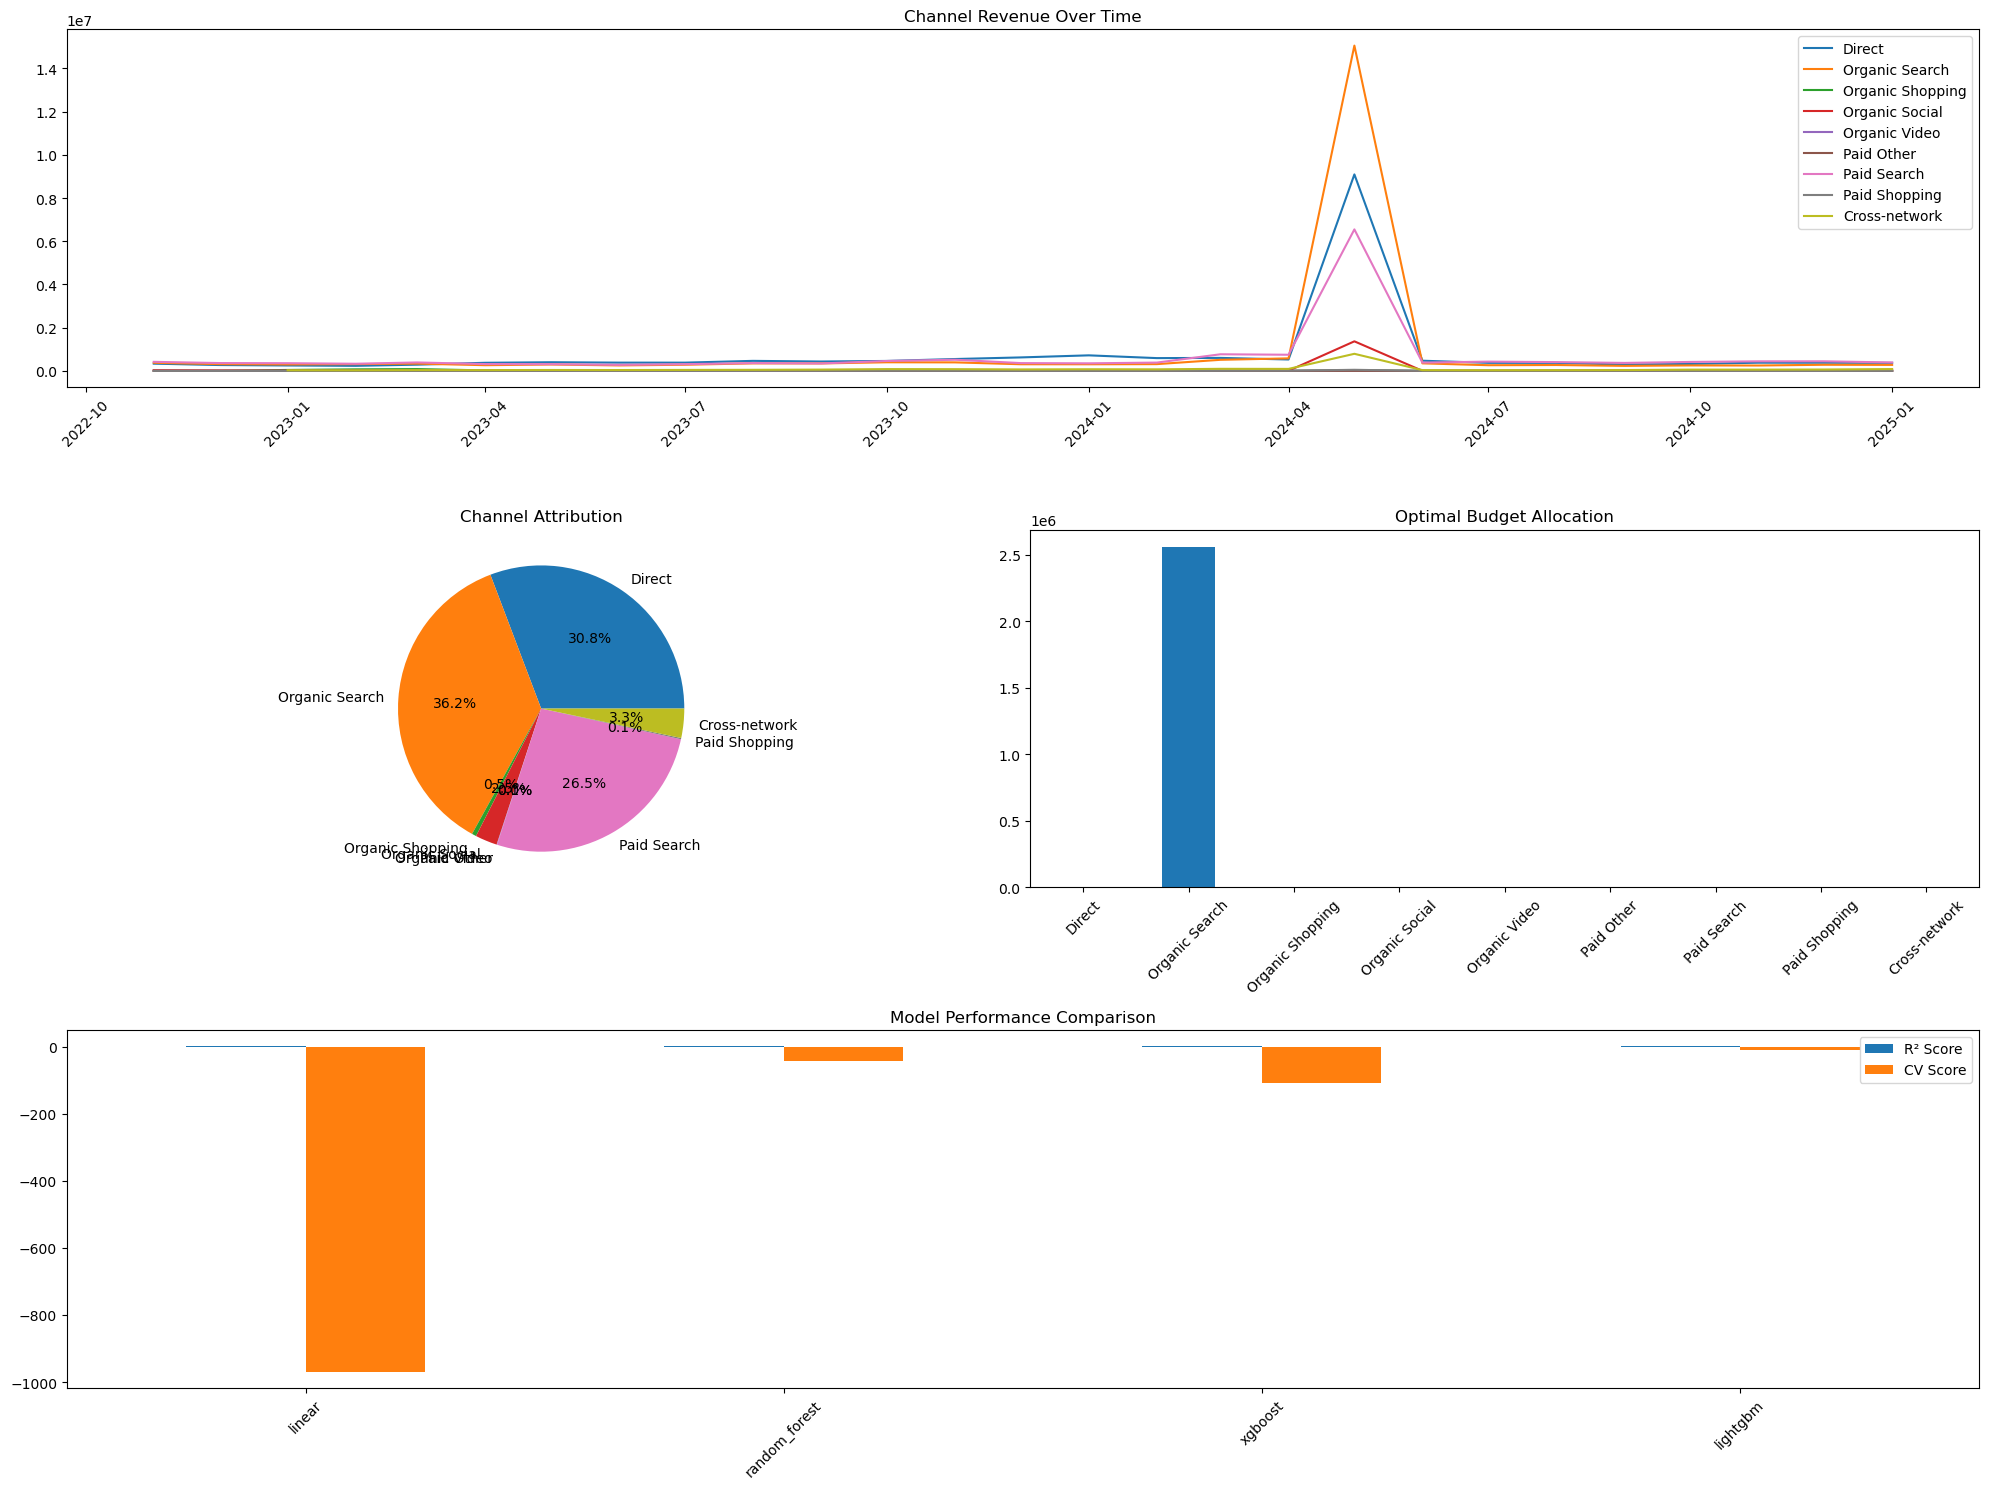

In [33]:
# Create and display dashboard
print("\nCreating visualization dashboard...")
create_mmm_dashboard(enhanced_ga4, attribution_results, optimal_allocation, model_results)

# Add the new conversion function here
def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(x) for x in obj]
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32,
                        np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

In [34]:
# Convert results to serializable format
results_summary = {
    'model_performance': convert_to_serializable(model_results),
    'channel_attribution': convert_to_serializable(attribution_results),
    'optimal_budget': convert_to_serializable(optimal_allocation)
}

# Save results
output_path = os.path.join("Resources", "mmm_analysis_results.json")
with open(output_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nAnalysis results saved to {output_path}")


Analysis results saved to Resources\mmm_analysis_results.json


In [35]:
# Print key insights
print("\nKey Insights:")
print("\nTop Performing Channels (by Attribution):")
for channel, contribution in sorted(
    attribution_results.items(),
    key=lambda x: x[1],
    reverse=True
)[:3]:
    print(f"- {channel}: {contribution*100:.1f}%")

print("\nBest Performing Model:")
best_model = max(model_results.items(), key=lambda x: x[1]['r2'])[0]
print(f"- {best_model} (R² Score: {model_results[best_model]['r2']:.3f})")

print("\nRecommended Budget Allocation:")
for channel, budget in sorted(
    optimal_allocation.items(),
    key=lambda x: x[1],
    reverse=True
)[:3]:
    print(f"- {channel}: ${budget:,.2f}")


Key Insights:

Top Performing Channels (by Attribution):
- Organic Search: 36.2%
- Direct: 30.8%
- Paid Search: 26.5%

Best Performing Model:
- xgboost (R² Score: 1.000)

Recommended Budget Allocation:
- Organic Search: $2,561,594.00
- Organic Shopping: $0.00
- Direct: $0.00


# Model Accuracy Analysis & Vizualization

In [36]:
# Define the accuracy analysis function
def calculate_metrics(y_true, y_pred):
    """Helper function to calculate all metrics"""
    return {
        'r2': r2_score(y_true, y_pred),
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

def perform_accuracy_analysis(models, X, y, feature_columns):
    """
    Perform comprehensive accuracy analysis for all models
    """
    accuracy_results = {}
    
    for name, model in models.items():
        print(f"\nAnalyzing {name} accuracy...")
        
        # Split data for temporal validation
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Basic metrics using helper function
        metrics = calculate_metrics(y_test, y_pred)
        
        # Channel-specific accuracy
        channel_accuracy = {}
        if 'Channel' in X.columns:
            for channel in X_test['Channel'].unique():
                channel_mask = X_test['Channel'] == channel
                if sum(channel_mask) > 0:
                    channel_metrics = calculate_metrics(
                        y_test[channel_mask],
                        y_pred[channel_mask]
                    )
                    channel_accuracy[channel] = channel_metrics
        
        # Temporal accuracy
        temporal_accuracy = {}
        if 'Quarter' in X.columns:
            for quarter in X_test['Quarter'].unique():
                quarter_mask = X_test['Quarter'] == quarter
                if sum(quarter_mask) > 0:
                    quarter_metrics = calculate_metrics(
                        y_test[quarter_mask],
                        y_pred[quarter_mask]
                    )
                    temporal_accuracy[f'Q{quarter}'] = quarter_metrics
        
        # Revenue range accuracy
        y_test_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
        y_test_df['revenue_bin'] = pd.qcut(y_test_df['actual'], q=4, 
                                         labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
        
        revenue_range_accuracy = {}
        for revenue_bin in y_test_df['revenue_bin'].unique():
            bin_mask = y_test_df['revenue_bin'] == revenue_bin
            if sum(bin_mask) > 0:
                bin_metrics = calculate_metrics(
                    y_test_df[bin_mask]['actual'],
                    y_test_df[bin_mask]['predicted']
                )
                revenue_range_accuracy[revenue_bin] = bin_metrics
        
        accuracy_results[name] = {
            'overall_metrics': metrics,
            'channel_accuracy': channel_accuracy,
            'temporal_accuracy': temporal_accuracy,
            'revenue_range_accuracy': revenue_range_accuracy
        }
        
        # Visualization
        plt.figure(figsize=(15, 10))
        
        # Actual vs Predicted
        plt.subplot(2, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Revenue')
        plt.ylabel('Predicted Revenue')
        plt.title(f'{name}: Actual vs Predicted')
        
        # Error Distribution
        plt.subplot(2, 2, 2)
        errors = y_test - y_pred
        plt.hist(errors, bins=50)
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        
        # Channel-wise MAPE
        if channel_accuracy:
            plt.subplot(2, 2, 3)
            channel_mapes = {k: v['mape'] for k, v in channel_accuracy.items()}
            plt.bar(channel_mapes.keys(), channel_mapes.values())
            plt.xticks(rotation=45)
            plt.ylabel('MAPE (%)')
            plt.title('Channel-wise MAPE')
        
        # Temporal MAPE
        if temporal_accuracy:
            plt.subplot(2, 2, 4)
            temporal_mapes = {k: v['mape'] for k, v in temporal_accuracy.items()}
            plt.bar(temporal_mapes.keys(), temporal_mapes.values())
            plt.ylabel('MAPE (%)')
            plt.title('Quarterly MAPE')
        
        plt.tight_layout()
        plt.show()
    
    return accuracy_results



Analyzing linear accuracy...


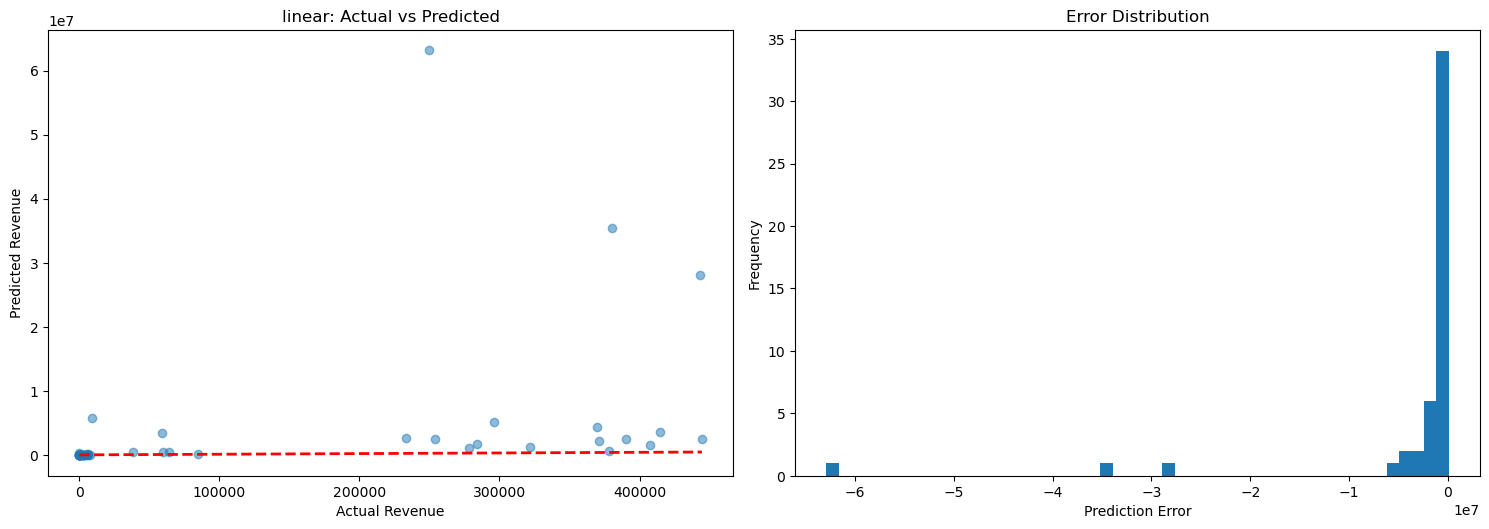


Analyzing random_forest accuracy...


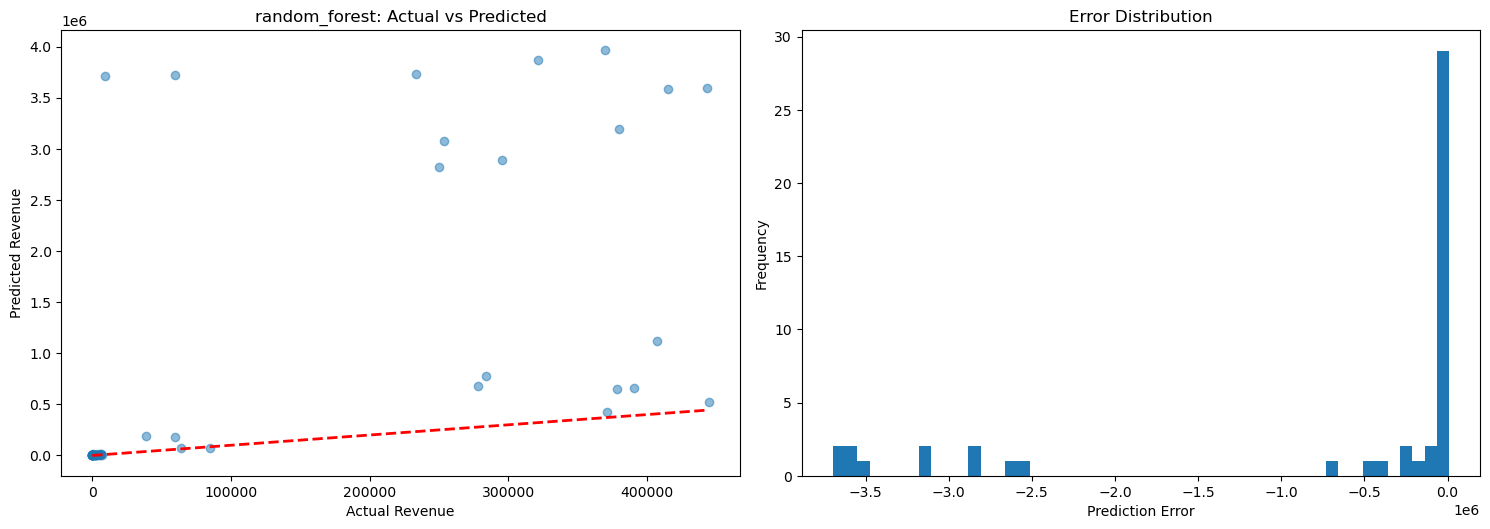


Analyzing xgboost accuracy...


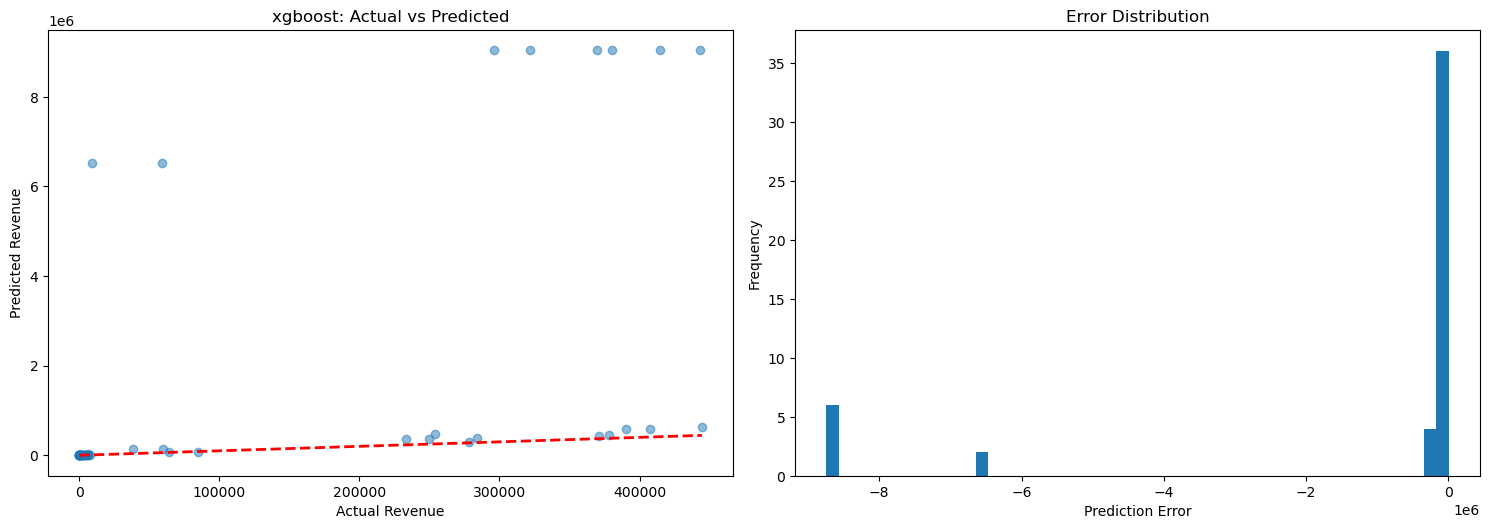


Analyzing lightgbm accuracy...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 190, number of used features: 12
[LightGBM] [Info] Start training from score 310354.320036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

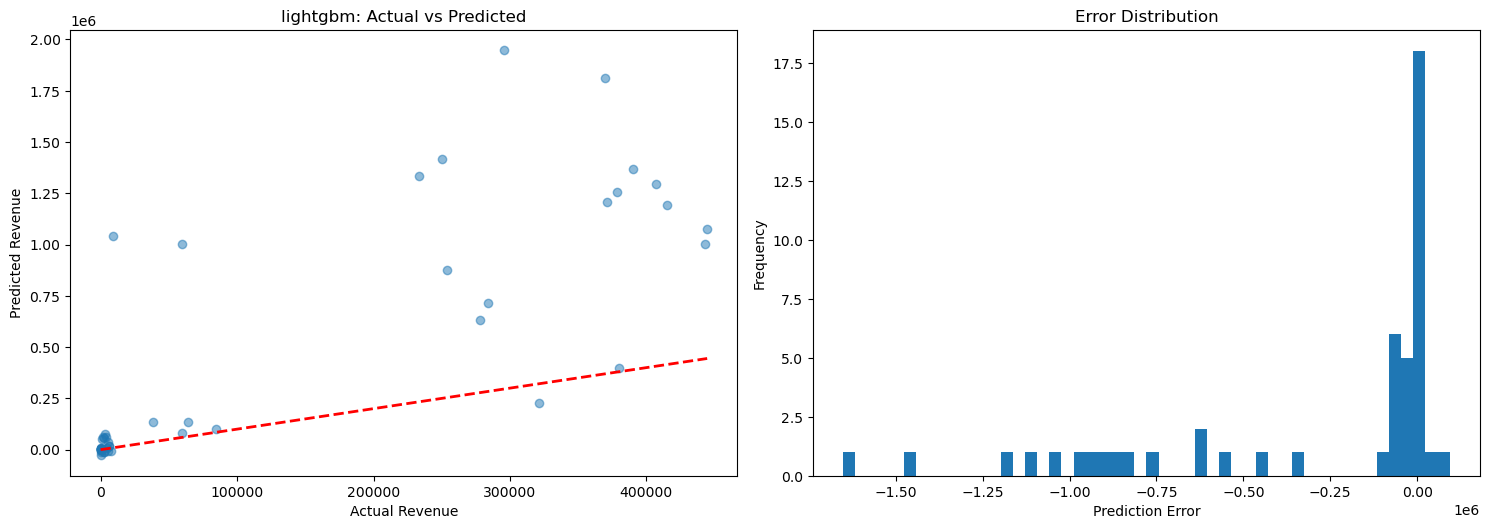

In [37]:
# Perform accuracy analysis
accuracy_results = perform_accuracy_analysis(models, X, y, feature_columns)

# Save accuracy results
results_summary['accuracy_analysis'] = accuracy_results

# Feature Importance Analysis


Analyzing feature importance for linear...


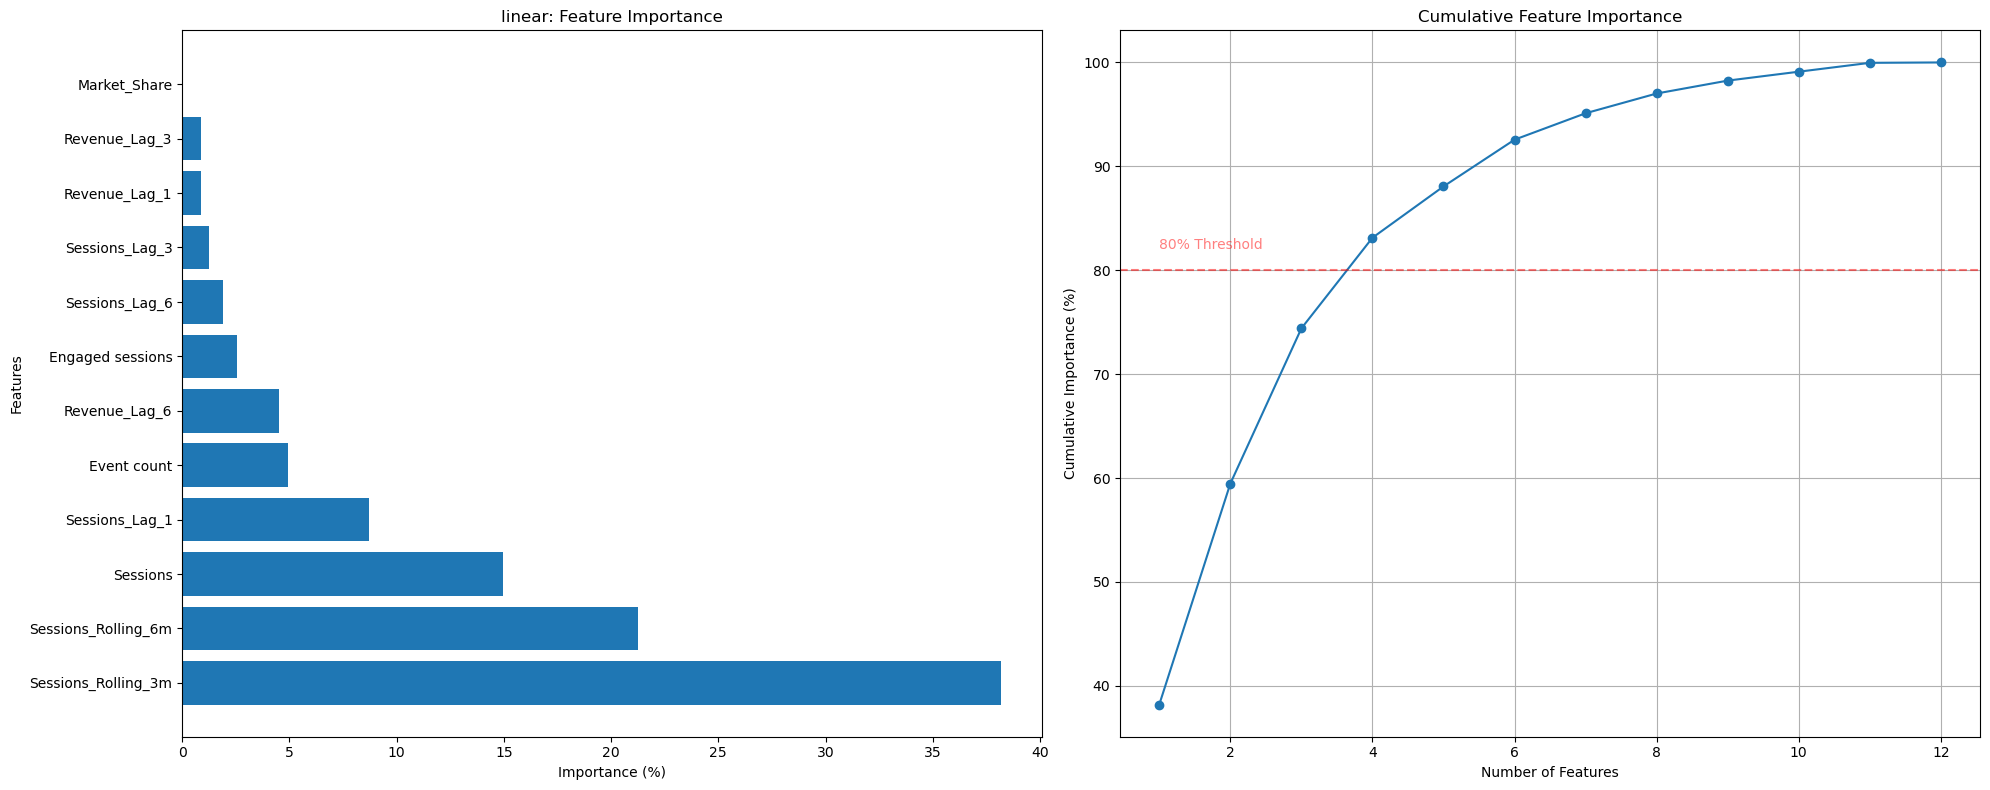


Feature Importance Summary for linear:

Top 5 Most Important Features:
- Sessions_Rolling_3m: 38.19%
- Sessions_Rolling_6m: 21.27%
- Sessions: 14.95%
- Sessions_Lag_1: 8.72%
- Event count: 4.94%

Feature Group Importance:
- Lag Features: 18.08%
- Rolling Features: 59.45%
- Base Features: 22.47%


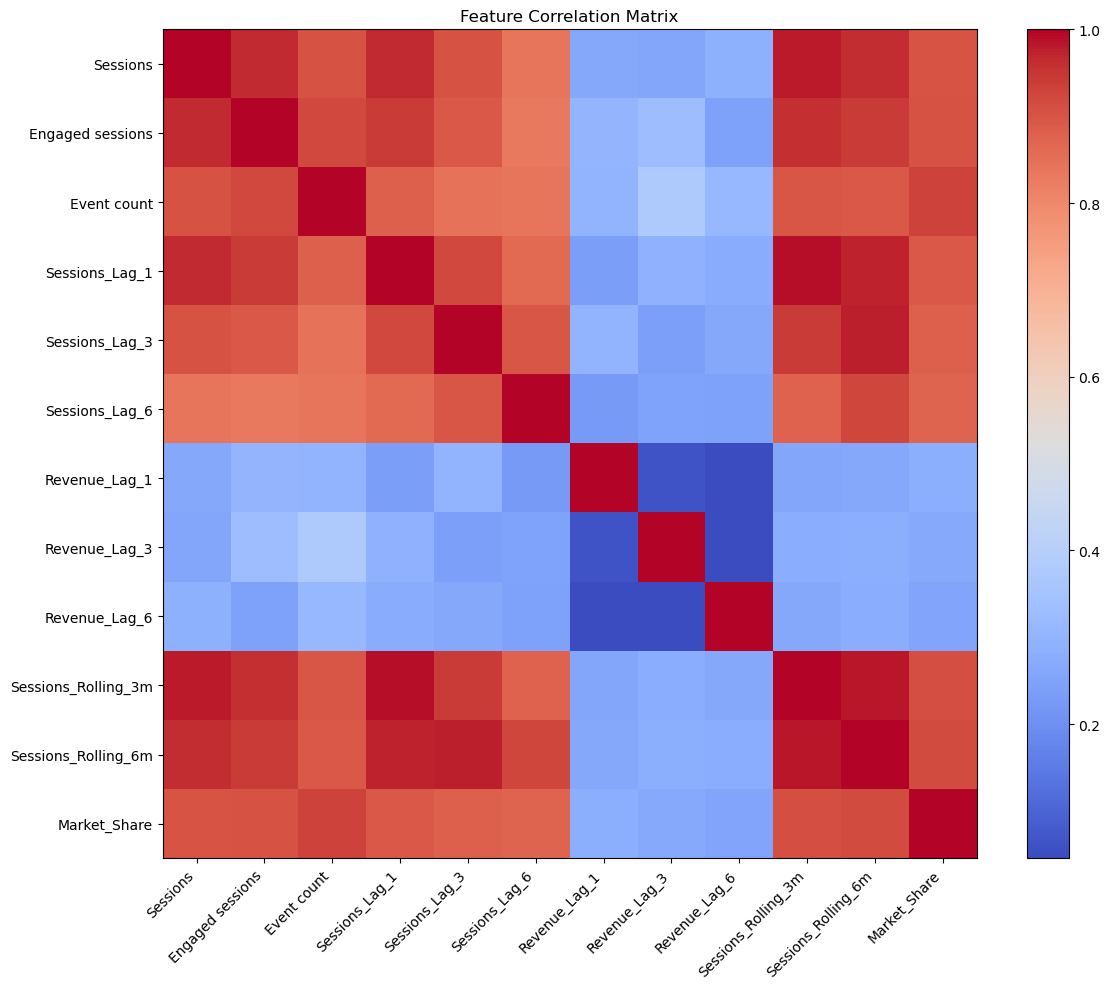


Highly Correlated Features (>0.8):
- Sessions & Engaged sessions: 0.97
- Sessions & Event count: 0.91
- Sessions & Sessions_Lag_1: 0.97
- Sessions & Sessions_Lag_3: 0.91
- Sessions & Sessions_Lag_6: 0.84
- Sessions & Sessions_Rolling_3m: 0.98
- Sessions & Sessions_Rolling_6m: 0.96
- Sessions & Market_Share: 0.90
- Engaged sessions & Event count: 0.92
- Engaged sessions & Sessions_Lag_1: 0.94
- Engaged sessions & Sessions_Lag_3: 0.89
- Engaged sessions & Sessions_Lag_6: 0.83
- Engaged sessions & Sessions_Rolling_3m: 0.96
- Engaged sessions & Sessions_Rolling_6m: 0.94
- Engaged sessions & Market_Share: 0.91
- Event count & Sessions_Lag_1: 0.88
- Event count & Sessions_Lag_3: 0.84
- Event count & Sessions_Lag_6: 0.84
- Event count & Sessions_Rolling_3m: 0.90
- Event count & Sessions_Rolling_6m: 0.89
- Event count & Market_Share: 0.93
- Sessions_Lag_1 & Sessions_Lag_3: 0.92
- Sessions_Lag_1 & Sessions_Lag_6: 0.86
- Sessions_Lag_1 & Sessions_Rolling_3m: 0.99
- Sessions_Lag_1 & Sessions_Rol

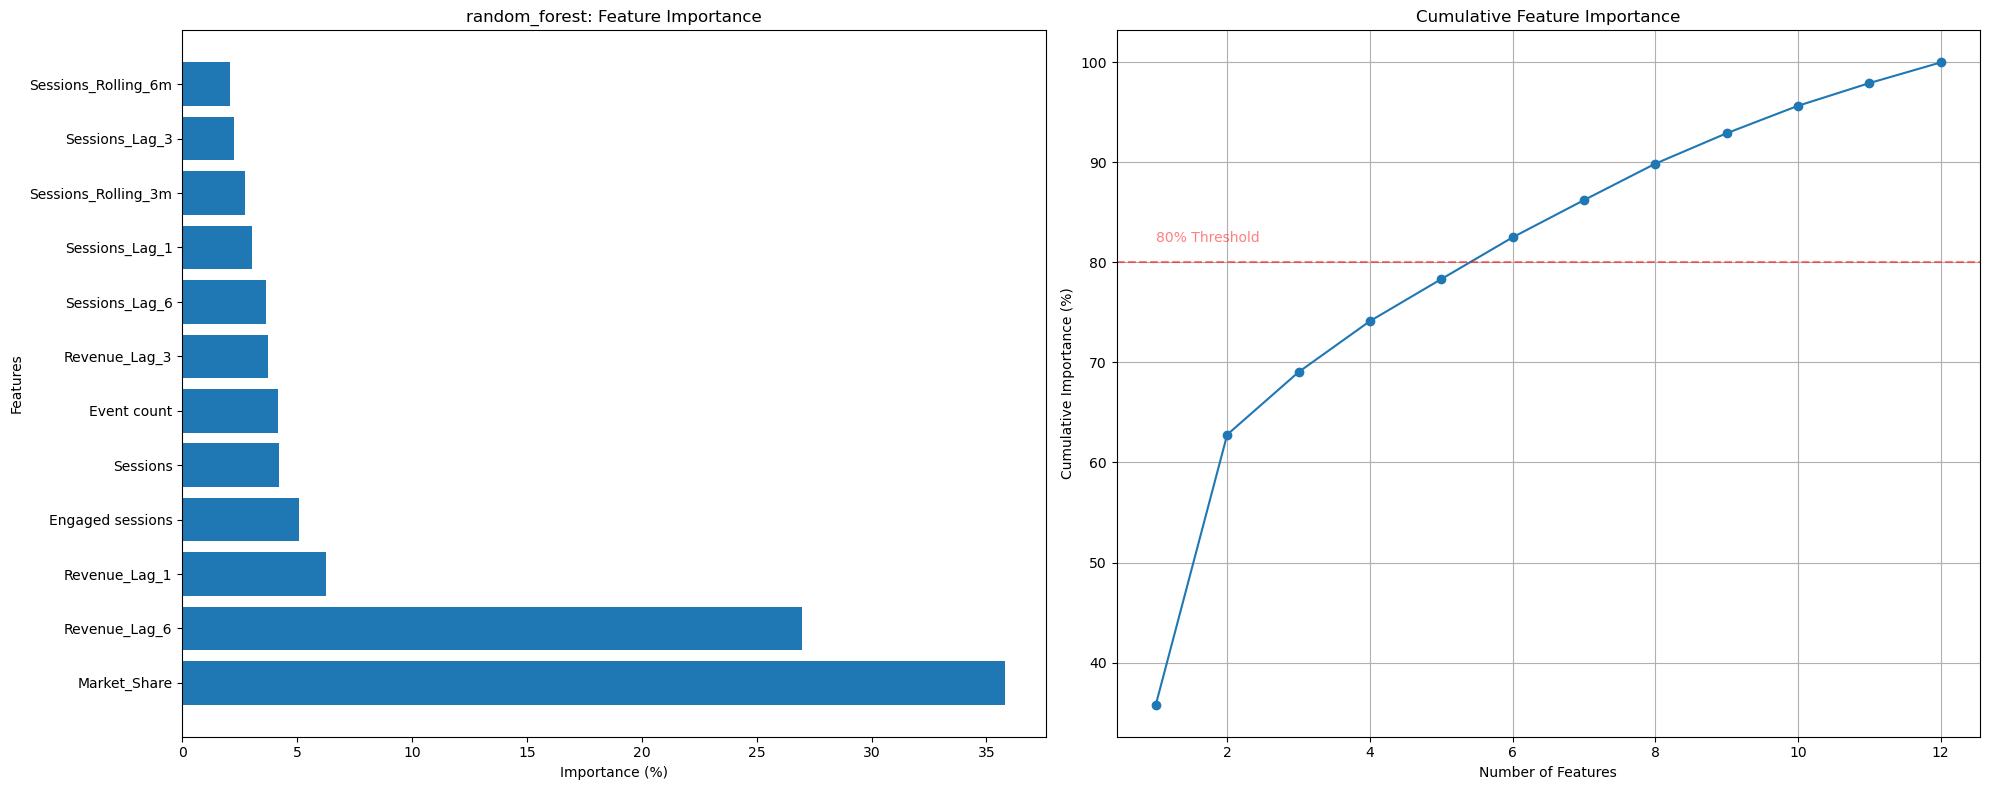


Feature Importance Summary for random_forest:

Top 5 Most Important Features:
- Market_Share: 35.79%
- Revenue_Lag_6: 26.99%
- Revenue_Lag_1: 6.25%
- Engaged sessions: 5.09%
- Sessions: 4.20%

Feature Group Importance:
- Lag Features: 45.93%
- Rolling Features: 4.81%
- Base Features: 49.27%


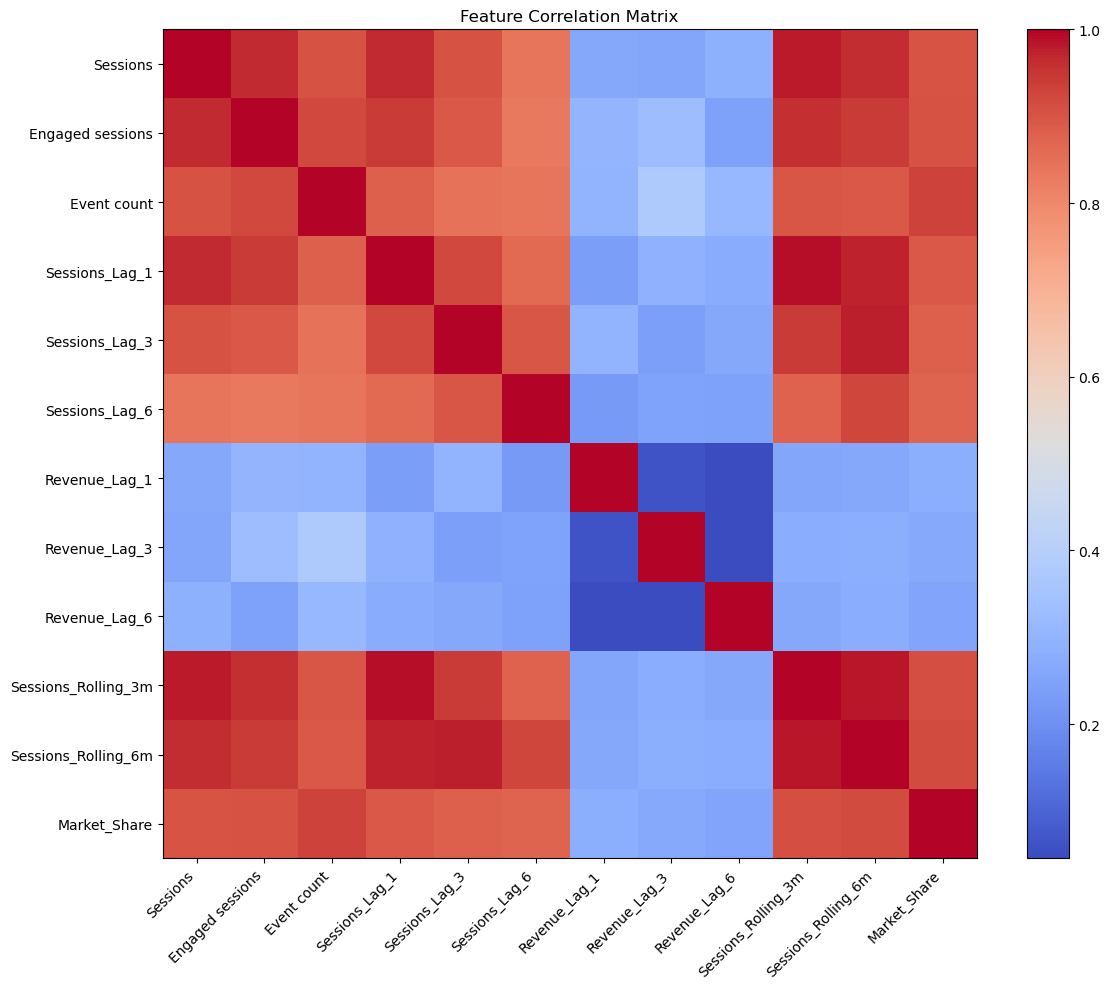


Highly Correlated Features (>0.8):
- Sessions & Engaged sessions: 0.97
- Sessions & Event count: 0.91
- Sessions & Sessions_Lag_1: 0.97
- Sessions & Sessions_Lag_3: 0.91
- Sessions & Sessions_Lag_6: 0.84
- Sessions & Sessions_Rolling_3m: 0.98
- Sessions & Sessions_Rolling_6m: 0.96
- Sessions & Market_Share: 0.90
- Engaged sessions & Event count: 0.92
- Engaged sessions & Sessions_Lag_1: 0.94
- Engaged sessions & Sessions_Lag_3: 0.89
- Engaged sessions & Sessions_Lag_6: 0.83
- Engaged sessions & Sessions_Rolling_3m: 0.96
- Engaged sessions & Sessions_Rolling_6m: 0.94
- Engaged sessions & Market_Share: 0.91
- Event count & Sessions_Lag_1: 0.88
- Event count & Sessions_Lag_3: 0.84
- Event count & Sessions_Lag_6: 0.84
- Event count & Sessions_Rolling_3m: 0.90
- Event count & Sessions_Rolling_6m: 0.89
- Event count & Market_Share: 0.93
- Sessions_Lag_1 & Sessions_Lag_3: 0.92
- Sessions_Lag_1 & Sessions_Lag_6: 0.86
- Sessions_Lag_1 & Sessions_Rolling_3m: 0.99
- Sessions_Lag_1 & Sessions_Rol

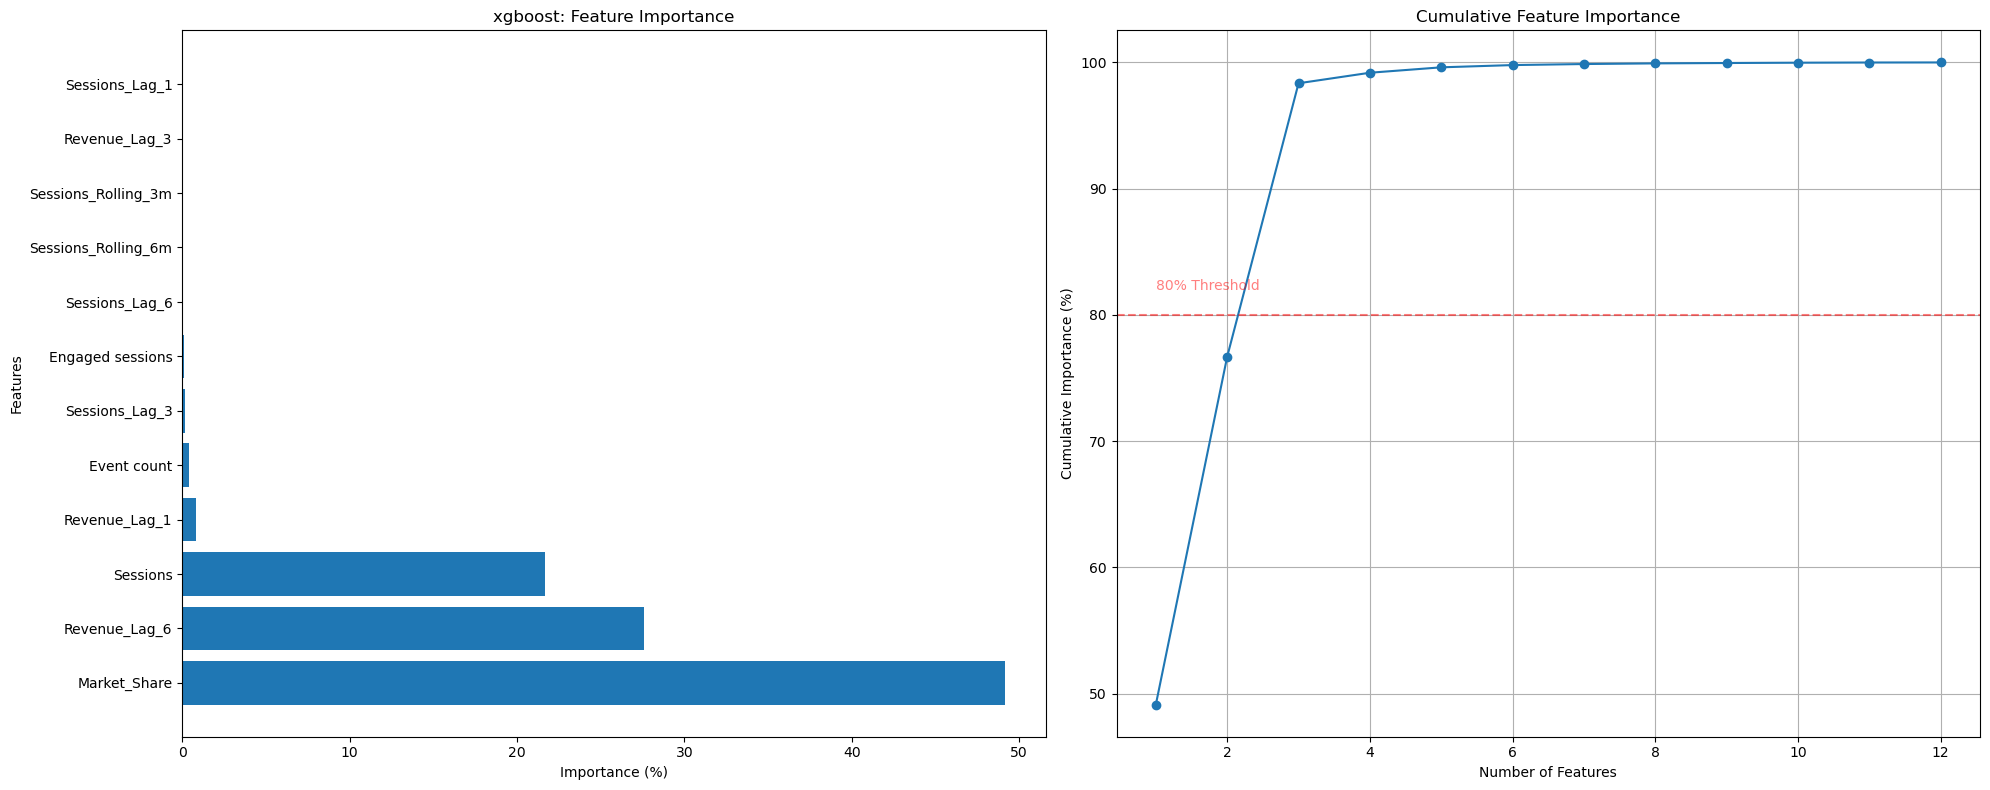


Feature Importance Summary for xgboost:

Top 5 Most Important Features:
- Market_Share: 49.13%
- Revenue_Lag_6: 27.56%
- Sessions: 21.66%
- Revenue_Lag_1: 0.83%
- Event count: 0.43%

Feature Group Importance:
- Lag Features: 28.64%
- Rolling Features: 0.05%
- Base Features: 71.30%


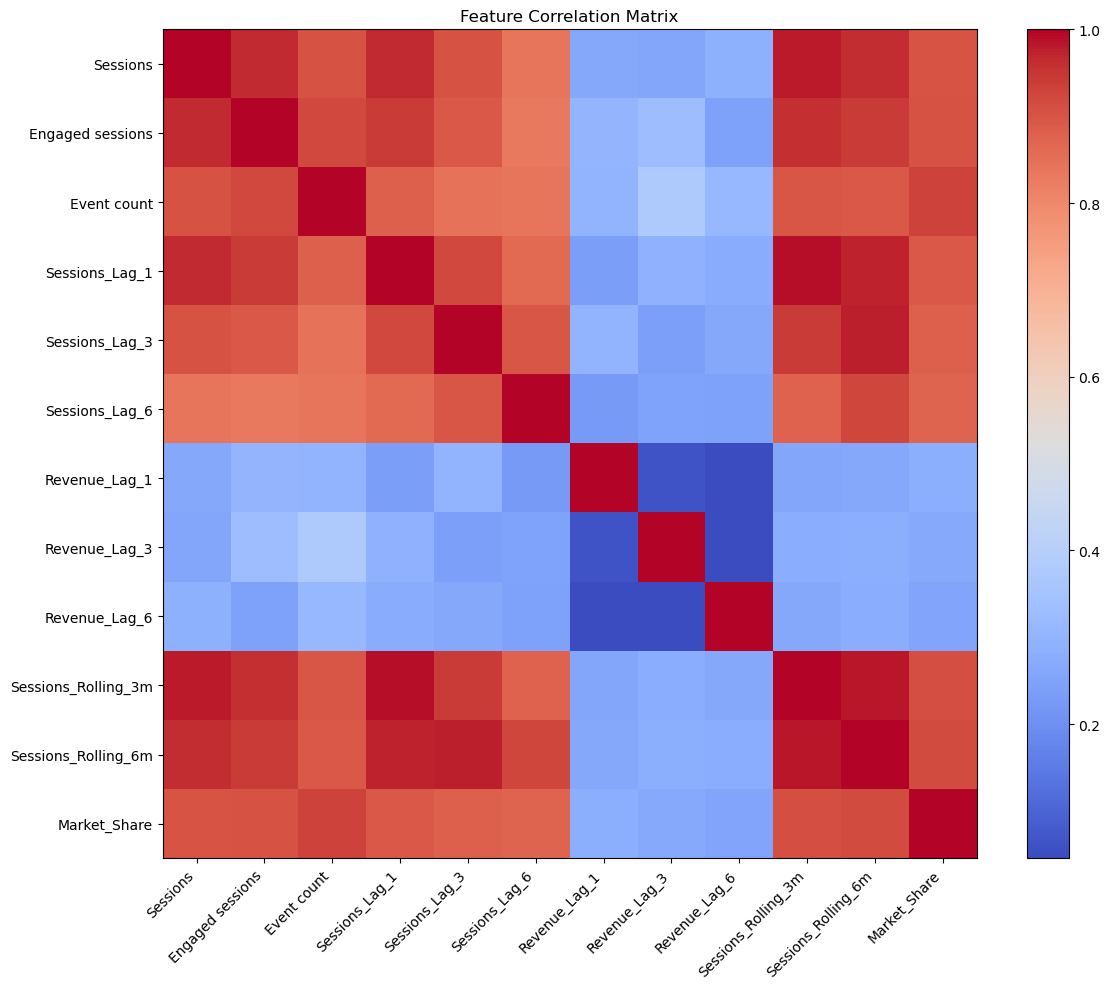


Highly Correlated Features (>0.8):
- Sessions & Engaged sessions: 0.97
- Sessions & Event count: 0.91
- Sessions & Sessions_Lag_1: 0.97
- Sessions & Sessions_Lag_3: 0.91
- Sessions & Sessions_Lag_6: 0.84
- Sessions & Sessions_Rolling_3m: 0.98
- Sessions & Sessions_Rolling_6m: 0.96
- Sessions & Market_Share: 0.90
- Engaged sessions & Event count: 0.92
- Engaged sessions & Sessions_Lag_1: 0.94
- Engaged sessions & Sessions_Lag_3: 0.89
- Engaged sessions & Sessions_Lag_6: 0.83
- Engaged sessions & Sessions_Rolling_3m: 0.96
- Engaged sessions & Sessions_Rolling_6m: 0.94
- Engaged sessions & Market_Share: 0.91
- Event count & Sessions_Lag_1: 0.88
- Event count & Sessions_Lag_3: 0.84
- Event count & Sessions_Lag_6: 0.84
- Event count & Sessions_Rolling_3m: 0.90
- Event count & Sessions_Rolling_6m: 0.89
- Event count & Market_Share: 0.93
- Sessions_Lag_1 & Sessions_Lag_3: 0.92
- Sessions_Lag_1 & Sessions_Lag_6: 0.86
- Sessions_Lag_1 & Sessions_Rolling_3m: 0.99
- Sessions_Lag_1 & Sessions_Rol

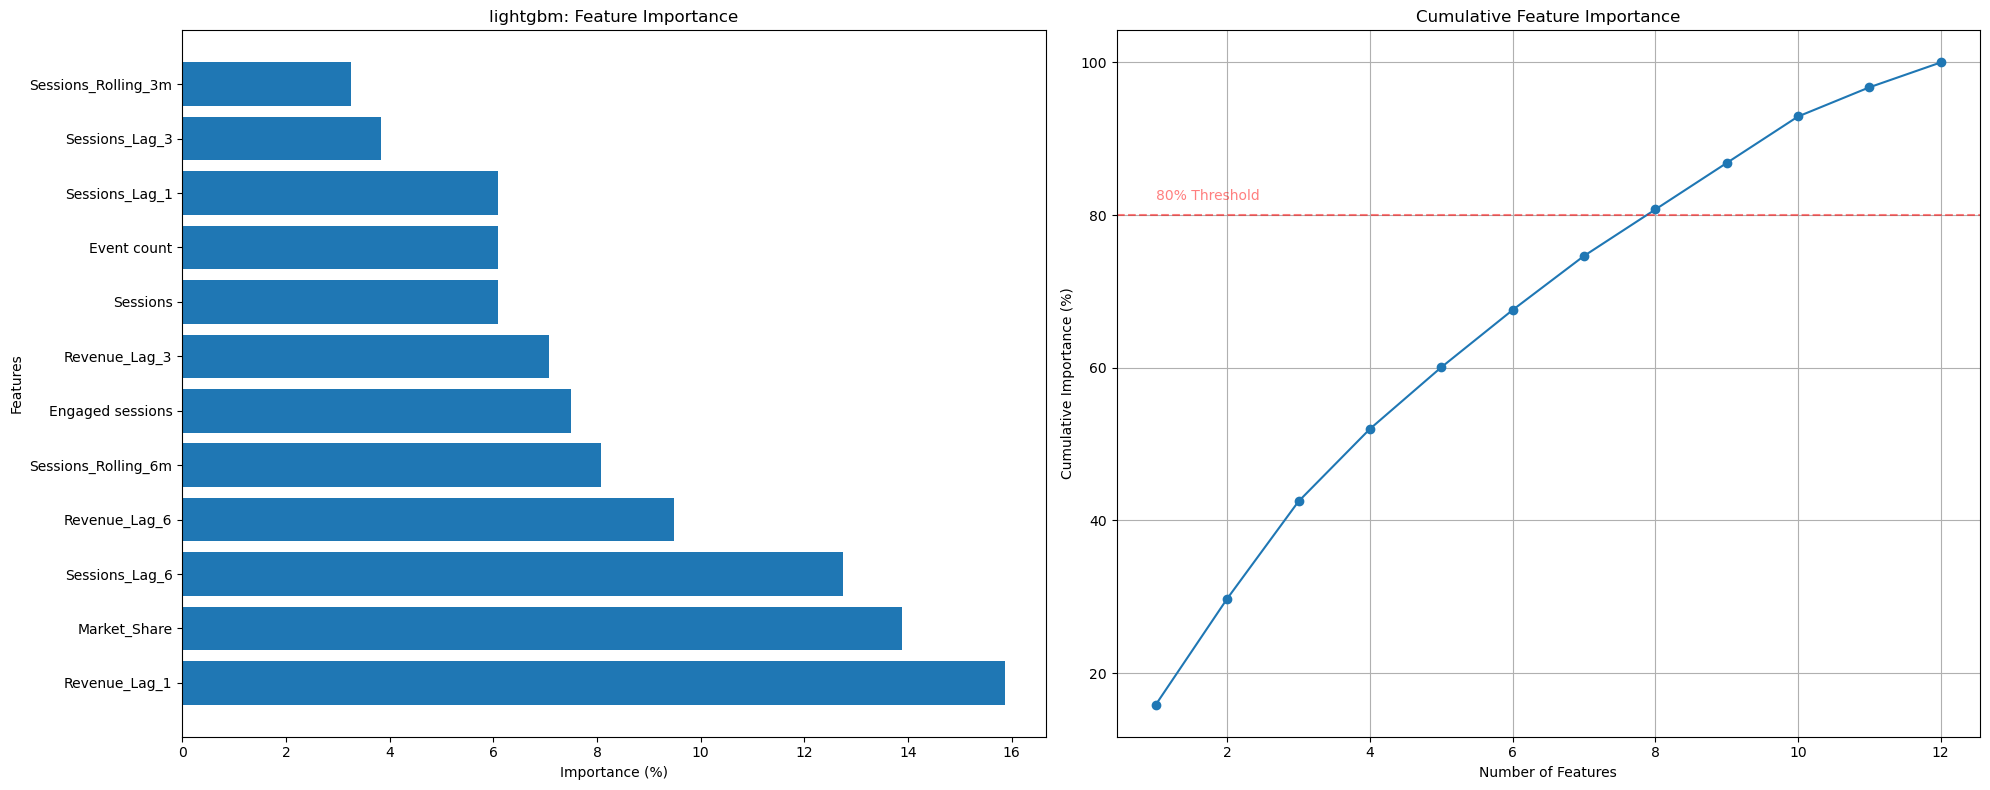


Feature Importance Summary for lightgbm:

Top 5 Most Important Features:
- Revenue_Lag_1: 15.86%
- Market_Share: 13.88%
- Sessions_Lag_6: 12.75%
- Revenue_Lag_6: 9.49%
- Sessions_Rolling_6m: 8.07%

Feature Group Importance:
- Lag Features: 55.10%
- Rolling Features: 11.33%
- Base Features: 33.57%


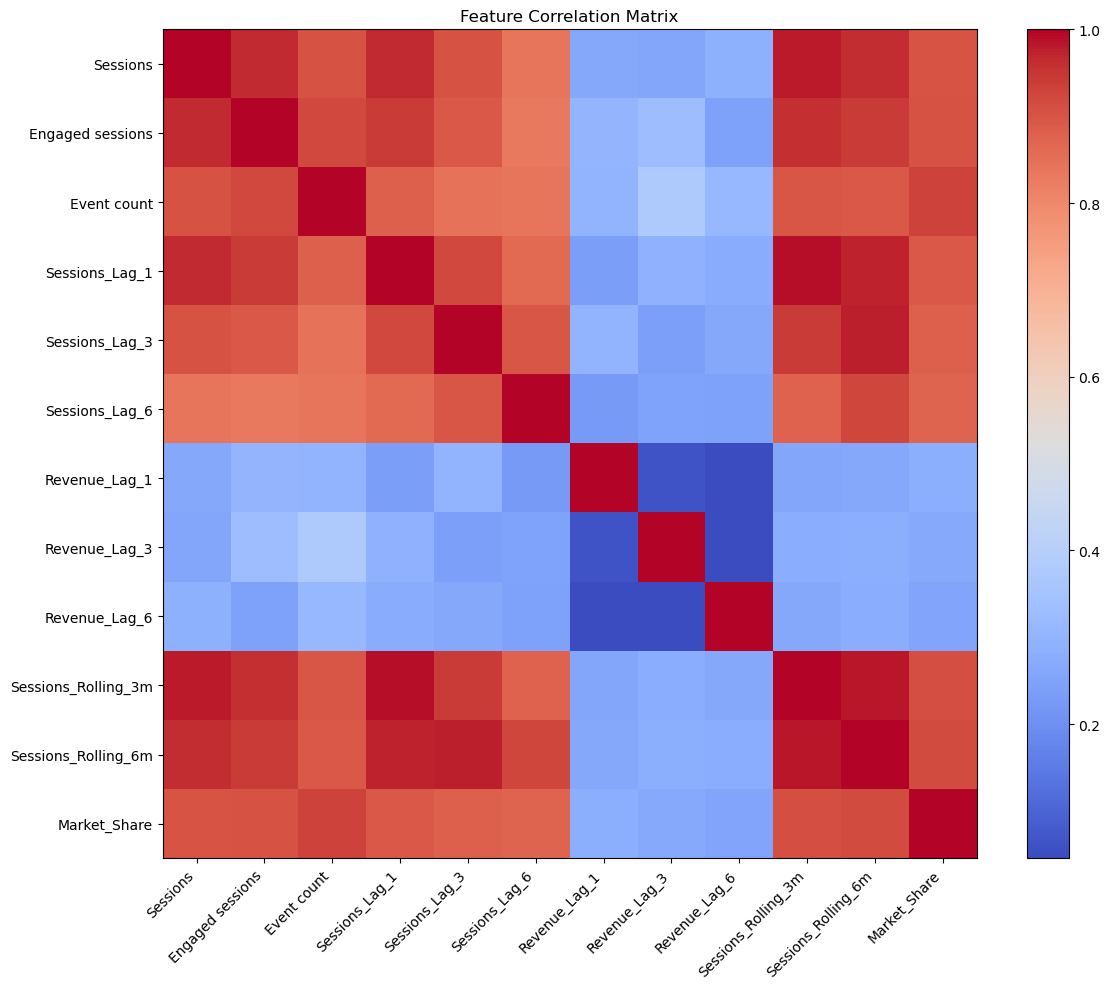


Highly Correlated Features (>0.8):
- Sessions & Engaged sessions: 0.97
- Sessions & Event count: 0.91
- Sessions & Sessions_Lag_1: 0.97
- Sessions & Sessions_Lag_3: 0.91
- Sessions & Sessions_Lag_6: 0.84
- Sessions & Sessions_Rolling_3m: 0.98
- Sessions & Sessions_Rolling_6m: 0.96
- Sessions & Market_Share: 0.90
- Engaged sessions & Event count: 0.92
- Engaged sessions & Sessions_Lag_1: 0.94
- Engaged sessions & Sessions_Lag_3: 0.89
- Engaged sessions & Sessions_Lag_6: 0.83
- Engaged sessions & Sessions_Rolling_3m: 0.96
- Engaged sessions & Sessions_Rolling_6m: 0.94
- Engaged sessions & Market_Share: 0.91
- Event count & Sessions_Lag_1: 0.88
- Event count & Sessions_Lag_3: 0.84
- Event count & Sessions_Lag_6: 0.84
- Event count & Sessions_Rolling_3m: 0.90
- Event count & Sessions_Rolling_6m: 0.89
- Event count & Market_Share: 0.93
- Sessions_Lag_1 & Sessions_Lag_3: 0.92
- Sessions_Lag_1 & Sessions_Lag_6: 0.86
- Sessions_Lag_1 & Sessions_Rolling_3m: 0.99
- Sessions_Lag_1 & Sessions_Rol

In [38]:
def analyze_feature_importance(models, X, feature_columns):
    """
    Analyze and visualize feature importance across different models
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    X : pandas DataFrame
        Feature matrix
    feature_columns : list
        List of feature names
    
    Returns:
    --------
    dict
        Feature importance results for each model
    """
    importance_results = {}
    
    # Use default style instead of seaborn
    plt.style.use('default')
    
    for name, model in models.items():
        print(f"\nAnalyzing feature importance for {name}...")
        
        # Get feature importance based on model type
        if hasattr(model.named_steps['model'], 'feature_importances_'):
            importance = model.named_steps['model'].feature_importances_
            importance_type = 'feature_importances'
        elif hasattr(model.named_steps['model'], 'coef_'):
            importance = np.abs(model.named_steps['model'].coef_)
            importance_type = 'coefficients'
        else:
            print(f"Model {name} doesn't support feature importance analysis")
            continue
            
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': importance
        })
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        # Calculate relative importance
        importance_df['importance_percentage'] = (
            importance_df['importance'] / importance_df['importance'].sum() * 100
        )
        
        # Store results
        importance_results[name] = {
            'importance_type': importance_type,
            'importance_values': importance_df.to_dict('records'),
            'top_features': importance_df.head(5)['feature'].tolist(),
            'bottom_features': importance_df.tail(5)['feature'].tolist()
        }
        
        # Visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Bar plot
        ax1.barh(importance_df['feature'], importance_df['importance_percentage'])
        ax1.set_title(f'{name}: Feature Importance')
        ax1.set_xlabel('Importance (%)')
        ax1.set_ylabel('Features')
        
        # Cumulative importance plot
        cumulative_importance = np.cumsum(importance_df['importance_percentage'])
        ax2.plot(range(1, len(cumulative_importance) + 1), 
                cumulative_importance, 
                marker='o')
        ax2.set_title('Cumulative Feature Importance')
        ax2.set_xlabel('Number of Features')
        ax2.set_ylabel('Cumulative Importance (%)')
        ax2.grid(True)
        
        # Add 80% threshold line
        ax2.axhline(y=80, color='r', linestyle='--', alpha=0.5)
        ax2.text(1, 82, '80% Threshold', color='r', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nFeature Importance Summary for {name}:")
        print("\nTop 5 Most Important Features:")
        for idx, row in importance_df.head().iterrows():
            print(f"- {row['feature']}: {row['importance_percentage']:.2f}%")
            
        # Calculate feature groups importance
        if any('Lag' in feat for feat in feature_columns):
            feature_groups = {
                'Lag Features': [col for col in feature_columns if 'Lag' in col],
                'Rolling Features': [col for col in feature_columns if 'Rolling' in col],
                'Base Features': [col for col in feature_columns 
                                if 'Lag' not in col and 'Rolling' not in col]
            }
            
            group_importance = {}
            for group_name, group_features in feature_groups.items():
                group_importance[group_name] = importance_df[
                    importance_df['feature'].isin(group_features)
                ]['importance_percentage'].sum()
            
            print("\nFeature Group Importance:")
            for group, imp in group_importance.items():
                print(f"- {group}: {imp:.2f}%")
        
        # Feature correlation analysis
        correlation_matrix = X[feature_columns].corr()
        
        plt.figure(figsize=(12, 10))
        plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(feature_columns)), feature_columns, rotation=45, ha='right')
        plt.yticks(range(len(feature_columns)), feature_columns)
        plt.title(f'Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # Identify highly correlated features
        high_correlation_threshold = 0.8
        high_corr_features = np.where(np.abs(correlation_matrix) > high_correlation_threshold)
        high_corr_features = [(correlation_matrix.index[x], 
                              correlation_matrix.columns[y], 
                              correlation_matrix.iloc[x, y])
                             for x, y in zip(*high_corr_features) 
                             if x != y and x < y]
        
        if high_corr_features:
            print("\nHighly Correlated Features (>0.8):")
            for feat1, feat2, corr in high_corr_features:
                print(f"- {feat1} & {feat2}: {corr:.2f}")
    
    return importance_results

# Run feature importance analysis
importance_results = analyze_feature_importance(models, X, feature_columns)

# Add results to summary
results_summary['feature_importance'] = {
    model_name: {
        'top_features': results['top_features'],
        'importance_type': results['importance_type']
    }
    for model_name, results in importance_results.items()
}